<a href="https://colab.research.google.com/github/AlexAlexeyuk/Alexander.Alexeyuk/blob/ready/%D0%9A%D0%BE%D0%BF%D0%B8%D1%8F_%D0%B1%D0%BB%D0%BE%D0%BA%D0%BD%D0%BE%D1%82%D0%B0_%22%D0%9E%D0%B1%D1%83%D1%87%D0%B5%D0%BD%D0%B8%D0%B5_%D0%BC%D0%BE%D0%B4%D0%B5%D0%BB%D0%B8_%D0%B8_%D0%B2%D1%8B%D0%B2%D0%BE%D0%B4%D1%8B_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Цель обучения моделей: 
* Построить модель, которая смогла бы минимизировать количество назначенных антибиотиков при нулевом уровне ложноотрицательных результатов
## Задачи:
* Построить наиболее эффективные модели машинного обучения для поставленной цели
* Произвести настройку параметров
* Оценить качество моделей и соотнести качество с поставленной целью
* Реализовать принцип решения задачи "обнуления" ложноотрицательных результатов путём стэкинга моделей, по аналогии с распространённым подходом в медицине
 -- консилиум, когда если даже один оценщик считает, что антибиотики показаны - определяем как показание к антибиотикам
го исхода.

## Импорт необходимых библиотек

In [32]:
import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import mannwhitneyu,ttest_ind, kruskal,chisquare, pearsonr, spearmanr
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt 
!pip install colorama
from colorama import Fore, Back, Style 
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from mlxtend.plotting import plot_confusion_matrix
from plotly.offline import plot, iplot, init_notebook_mode
from sklearn.ensemble import RandomForestClassifier
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import plotly.express as px
from statsmodels.formula.api import ols
import plotly.graph_objs as gobj
init_notebook_mode(connected=True)
import warnings
warnings.filterwarnings("ignore")
import plotly.figure_factory as ff
import tensorflow as tf
from tensorflow import keras
import os
import tempfile
import matplotlib as mpl
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
from colorama import Fore, Back, Style 
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from mlxtend.plotting import plot_confusion_matrix
from plotly.offline import plot, iplot, init_notebook_mode
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import plotly.express as px
from statsmodels.formula.api import ols
import plotly.graph_objs as gobj
init_notebook_mode(connected=True)
warnings.filterwarnings("ignore")
import plotly.figure_factory as ff
%matplotlib inline
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
!pip install catboost
from catboost import CatBoostClassifier

In [33]:
df = pd.read_csv('/content/covid_data.csv')
df = df.drop('Unnamed: 0', axis=1)

In [55]:
# разделяем набор данных на тренировочную, тестовую и валидационную части и нормализуем данные
X = df.drop('Ab_ind', axis=1)  
Y = df['Ab_ind']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, 
                                                    test_size = 0.20,
                                                    stratify = Y, 
                                                    random_state = 42)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, 
                                                  test_size = 0.20, 
                                                  stratify = Y_train, 
                                                  random_state = 42)
train = X_train.copy()
test = X_test.copy()
valid = X_val.copy()
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)


## Наиболее эффективные алгоритмы машинного обучения

In [35]:
def all_estimators(X_train, X_test, Y_train, Y_test):
  """Функция - все оценщики

  На вход подаются уже отскалированные данные: тренировочная и тестовая  подвыборки.

  На выходе - словарь с предсказаниями на тестовой выборке
  
  """
  # подбор параметров происходил при помощи GridSearch с кросс-валидацией
  log_reg = LogisticRegression(C=5, 
                             tol=0.001,  
                             solver = 'sag', 
                             class_weight = {0:1, 1:6},
                             max_iter=200,
                             random_state=123,
                             n_jobs=-1
                             )
  log_reg.fit(X_train, Y_train)
  log_reg_pred_test = log_reg.predict(X_test)
  # подбор параметров происходил при помощи GridSearch с кросс-валидацией
  sv_clf = SVC(C=10, 
             gamma=0.001, 
             kernel='rbf', 
             class_weight={0:1, 1:7},
             random_state=123
            )
  sv_clf.fit(X_train, Y_train)
  sv_clf_pred_test = sv_clf.predict(X_test)


  model = CatBoostClassifier(
    eval_metric='F1',
    random_seed=63,
    iterations=200,
    learning_rate=0.03,
    class_weights = {0:1, 1:66}
    )
  model.fit(
    X_train, Y_train,
    
    verbose=False,
    plot=True
    )
  cat_pred_test = model.predict(data=X_test)


  # подбор параметров осуществлялся при помощи библиотеки FLAML
  lg=LGBMClassifier(boosting_type='gbdt', 
               colsample_bytree=0.8806179764705304, importance_type='split',
               learning_rate=0.09491017198517485, max_bin=511, max_depth=-1,
               min_child_samples=20, min_child_weight=1.1065178250743684,
               min_split_gain=0.0, n_estimators=47, n_jobs=-1, num_leaves=11,
               objective='binary', random_state=None,
               reg_alpha=0.00032671919026157256,
               reg_lambda=9.877648346776016e-05, silent=True, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0, class_weight = {0:1, 1:6}
    )
  lg.fit(X_train,Y_train)
  ypred_test = lg.predict(X_test)

  # подбор параметров осуществлялся при помощи библиотеки FLAML
  from xgboost import XGBClassifier
  xgb = XGBClassifier(base_score=0.5, booster='gbtree',
              colsample_bylevel=0.8556442483251352, colsample_bynode=1,
              colsample_bytree=0.9603522526553223, gamma=0,
              grow_policy='lossguide', learning_rate=0.3163852099341715,
              max_delta_step=0, max_depth=0, max_leaves=9,
              min_child_weight=0.06944036690114372, missing=None,
              n_estimators=56, n_jobs=-1, nthread=None,
              objective='binary:logistic', random_state=0,
              reg_alpha=1.5172673605832548e-08, reg_lambda=0.002879912987380904,
              scale_pos_weight=1, seed=None, silent=None, subsample=1.0,
              tree_method='hist', verbosity=0)
  xgb.fit(X_train,Y_train)
  xgbpred_test = xgb.predict(X_test)

  # подбор параметров осуществлялся при помощи библиотеки FLAML
  rf = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight={0:1, 1:6},
                       criterion='gini', max_depth=None,
                       max_features=0.25004979739235667, max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=64, n_jobs=-1, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)
  rf.fit(X_train,Y_train)
  rfpred_test = rf.predict(X_test)

  all_pred_test = {'Logistic': log_reg_pred_test, "SVM": sv_clf_pred_test,
                   "CatBoost": cat_pred_test, "LGBM": ypred_test, "XGB":xgbpred_test,
                   "RF":rfpred_test,
                   "Actual_labels": Y_test
                   }

  return all_pred_test

In [36]:
test_matrix = all_estimators(X_train=X_train, X_test=X_test, Y_train=Y_train, Y_test=Y_test)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [37]:
# формируем матрицу предсказаний моделей
test_matrix = pd.DataFrame(test_matrix)

In [38]:
# обновляем индексы,чтобы не было  проблем с дальнейшей склейкой столбцов
test_matrix = test_matrix.reset_index()

In [39]:
#добавляем оценщиков к общим матрицам оценок
Y_test = Y_test.reset_index()
test_matrix['Actual_labels'] = Y_test["Ab_ind"]

In [40]:
pd.options.display.max_rows = 999
test_matrix[test_matrix['Actual_labels'] == 1]

,index,Logistic,SVM,CatBoost,LGBM,XGB,RF,Actual_labels
0,687,1,1,1,0,0,0,1
2,155,0,0,0,0,0,0,1
9,15,0,0,1,0,0,0,1
19,771,1,1,1,1,0,0,1
21,248,1,1,1,0,0,0,1
22,582,1,1,1,1,1,1,1
26,366,1,1,1,1,1,0,1
27,732,0,0,1,0,0,0,1
29,551,1,1,1,1,1,0,1
38,577,1,1,1,1,0,0,1


Следует обратить внимание, что есть запись, где ни одна модель не определила показание к АБ-терапии, что плохо, учитывая цель - 0 ложноотрицательных значений

In [41]:
def plot_cm(labels, predictions, p=0.5):
  """Функция матрица несоответствий.

  На вход - реальные таргеты и предсказанные
  На выходе матрица несоответствий
  """
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
  print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
  print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
  print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
  print('Total Fraudulent Transactions: ', np.sum(cm[1]))

Legitimate Transactions Detected (True Negatives):  52
Legitimate Transactions Incorrectly Detected (False Positives):  91
Fraudulent Transactions Missed (False Negatives):  1
Fraudulent Transactions Detected (True Positives):  29
Total Fraudulent Transactions:  30


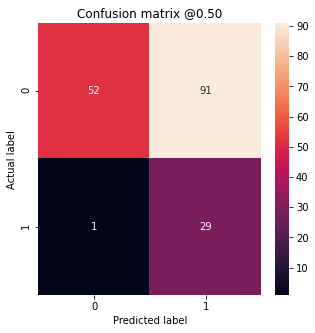

In [42]:
test_matrix['STACK'] = (test_matrix['Logistic'] + 
                        test_matrix['SVM'] +
                        test_matrix['CatBoost'] +
                        test_matrix['LGBM'] +
                       
                        test_matrix["XGB"] + 
                        test_matrix["RF"])
# Определил признак "Стэк", если он больше или равен 1 = 1, иначе = 0
test_matrix['STACK'] = test_matrix['STACK'].map(lambda 
                                                x: x + 1 - x 
                                                if x >= 1
                                                else 0)
plot_cm(test_matrix['Actual_labels'], test_matrix['STACK'])

В целом, результат очень даже неплох. Из более чем 170 записей только один ложноотрицательный результат



---


## Глубокое обучение

In [156]:
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
cleaned_df = df.copy()
val_features = np.array(X_val) # определяем все параметры и лейблы 
test_features = np.array(X_test)# как массивы, для более удобной работы
train_labels = np.array(Y_train)
val_labels = np.array(Y_val)
test_labels = np.array(Y_test)
train_features = np.array(X_train)
bool_train_labels = train_labels != 0
train_features = np.clip(train_features, -5, 5)
val_features = np.clip(val_features, -5, 5)
test_features = np.clip(test_features, -5, 5)

print('Training labels shape:', train_labels.shape)
print('Validation labels shape:', val_labels.shape)
print('Test labels shape:', test_labels.shape)

print('Training features shape:', train_features.shape)
print('Validation features shape:', val_features.shape)
print('Test features shape:', test_features.shape)

Training labels shape: (552,)
Validation labels shape: (138,)
Test labels shape: (173,)
Training features shape: (552, 24)
Validation features shape: (138, 24)
Test features shape: (173, 24)


In [157]:
METRICS = [ # определяем все метрики
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]
# определяем структуру нейронной сети
def make_model(metrics=METRICS, output_bias=None):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)
  model = keras.Sequential([
      keras.layers.Dense(
          16, activation='relu', # активатор - релу
          input_shape=(train_features.shape[-1],)),
      keras.layers.Dropout(0.5),
      keras.layers.Dense(1, activation='sigmoid',
                         bias_initializer=output_bias),
  ])

  model.compile(
      optimizer=keras.optimizers.Adam(lr=1e-3),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)

  return model

EPOCHS = 100
BATCH_SIZE = 2048

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc', # валидационная площадь под РОК-кривой как критерий ранней остановки
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)
model = make_model()
model.summary()
results = model.evaluate(train_features, train_labels, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_62 (Dense)             (None, 16)                400       
_________________________________________________________________
dropout_31 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_63 (Dense)             (None, 1)                 17        
Total params: 417
Trainable params: 417
Non-trainable params: 0
_________________________________________________________________
Loss: 0.6322


In [158]:
neg, pos = np.bincount(df['Ab_ind'])
initial_bias = np.log([pos/neg])
model = make_model(output_bias=initial_bias)
model.predict(train_features[:10])
results = model.evaluate(train_features, train_labels, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))
initial_weights = os.path.join(tempfile.mkdtemp(), 'initial_weights')
model.save_weights(initial_weights)

Loss: 0.5703


In [159]:
model = make_model()
model.load_weights(initial_weights)
model.layers[-1].bias.assign([0.0])
zero_bias_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(val_features, val_labels), 
    verbose=0)

In [160]:
model = make_model()
model.load_weights(initial_weights)
careful_bias_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(val_features, val_labels), 
    verbose=0)

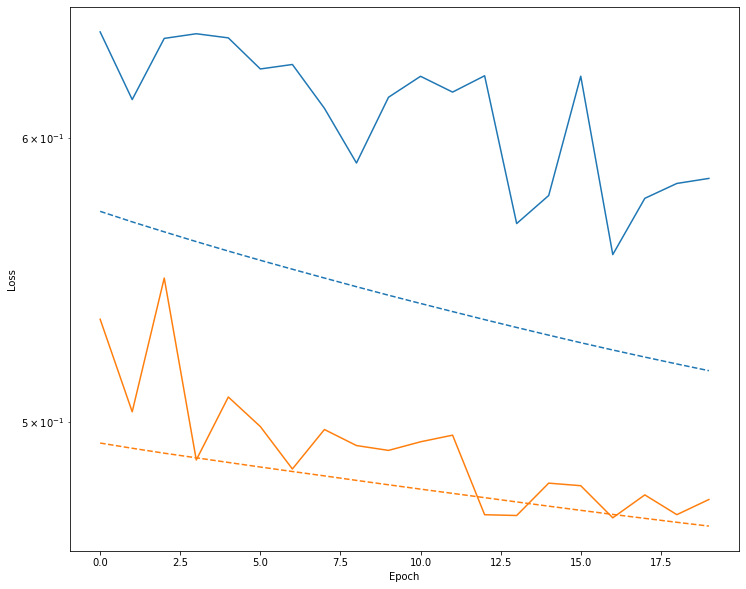

In [62]:
def plot_loss(history, label, n):
  # Use a log scale on y-axis to show the wide range of values.
  plt.semilogy(history.epoch, history.history['loss'],
               color=colors[n], label='Train ' + label)
  plt.semilogy(history.epoch, history.history['val_loss'],
               color=colors[n], label='Val ' + label,
               linestyle="--")
  plt.xlabel('Epoch')
  plt.ylabel('Loss')


plot_loss(zero_bias_history, "Zero Bias", 0)
plot_loss(careful_bias_history, "Careful Bias", 1)

In [161]:
model = make_model()
model.load_weights(initial_weights)
baseline_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(val_features, val_labels))

Epoch 1/100
1/1 [==============================] - 2s 2s/step - loss: 0.6315 - tp: 7.0000 - fp: 16.0000 - tn: 556.0000 - fn: 111.0000 - accuracy: 0.8159 - precision: 0.3043 - recall: 0.0593 - auc: 0.4372 - val_loss: 0.4913 - val_tp: 1.0000 - val_fp: 0.0000e+00 - val_tn: 114.0000 - val_fn: 23.0000 - val_accuracy: 0.8333 - val_precision: 1.0000 - val_recall: 0.0417 - val_auc: 0.5190
Epoch 2/100
1/1 [==============================] - 0s 49ms/step - loss: 0.6212 - tp: 5.0000 - fp: 14.0000 - tn: 444.0000 - fn: 89.0000 - accuracy: 0.8134 - precision: 0.2632 - recall: 0.0532 - auc: 0.3599 - val_loss: 0.4894 - val_tp: 1.0000 - val_fp: 0.0000e+00 - val_tn: 114.0000 - val_fn: 23.0000 - val_accuracy: 0.8333 - val_precision: 1.0000 - val_recall: 0.0417 - val_auc: 0.5227
Epoch 3/100
1/1 [==============================] - 0s 42ms/step - loss: 0.6099 - tp: 3.0000 - fp: 19.0000 - tn: 439.0000 - fn: 91.0000 - accuracy: 0.8007 - precision: 0.1364 - recall: 0.0319 - auc: 0.3898 - val_loss: 0.4874 - val_t

In [64]:
def plot_metrics(history):
  # определяем построение графиков обучения
  metrics = ['loss', 'auc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()

In [162]:
train_predictions_baseline = model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_baseline = model.predict(test_features, batch_size=BATCH_SIZE)

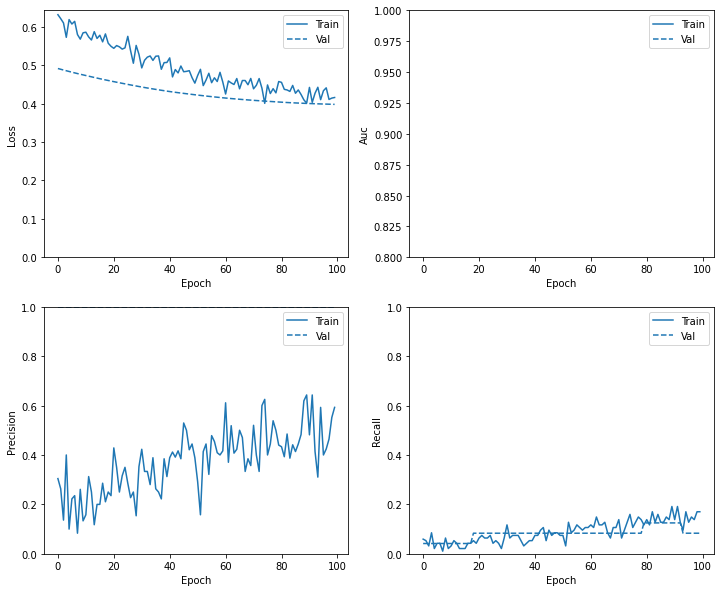

In [163]:
plot_metrics(baseline_history)

In [143]:
def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
  print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
  print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
  print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
  print('Total Fraudulent Transactions: ', np.sum(cm[1]))

loss :  0.40974316000938416
tp :  2.0
fp :  2.0
tn :  141.0
fn :  28.0
accuracy :  0.8265895843505859
precision :  0.5
recall :  0.06666667014360428
auc :  0.7357808947563171

Legitimate Transactions Detected (True Negatives):  141
Legitimate Transactions Incorrectly Detected (False Positives):  2
Fraudulent Transactions Missed (False Negatives):  28
Fraudulent Transactions Detected (True Positives):  2
Total Fraudulent Transactions:  30


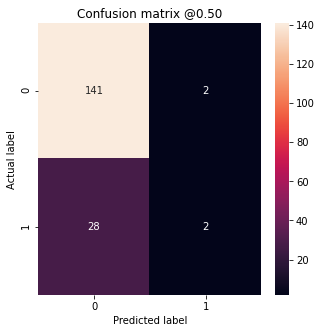

In [164]:
baseline_results = model.evaluate(test_features, test_labels,
                                  batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_baseline)

Итого, первое приближение. Т.к. имеет место дисбаланс в таргете, стандартные настройки работают не так как хотелось бы

In [145]:
def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

  plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  plt.xlim([-0.5,20])
  plt.ylim([80,100.5])
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')

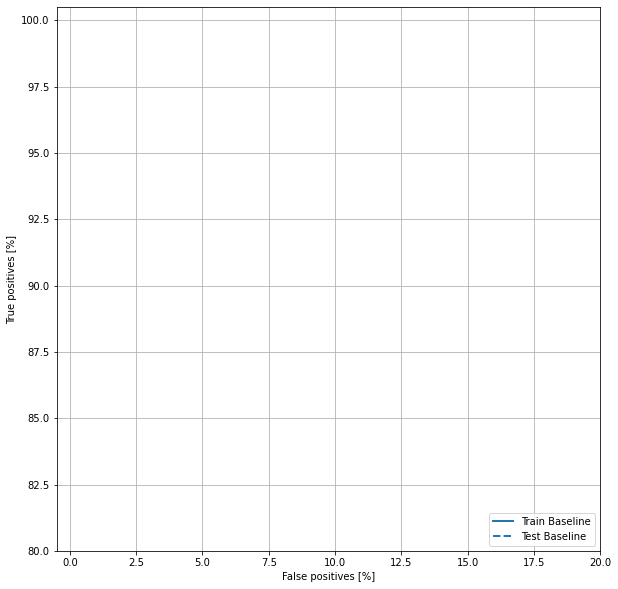

In [146]:
import sklearn
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')
plt.legend(loc='lower right')

In [165]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
neg, pos = np.bincount(df['Ab_ind'])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))
weight_for_0 = (1 / neg)*(total)/2.0 
weight_for_1 = (1 / pos)*(total)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

Examples:
    Total: 863
    Positive: 148 (17.15% of total)



In [166]:
weighted_model = make_model()
weighted_model.load_weights(initial_weights)

weighted_history = weighted_model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(val_features, val_labels),
    class_weight=class_weight) 

Epoch 1/100
1/1 [==============================] - 2s 2s/step - loss: 1.4613 - tp: 7.0000 - fp: 18.0000 - tn: 583.0000 - fn: 117.0000 - accuracy: 0.8138 - precision: 0.2800 - recall: 0.0565 - auc: 0.4807 - val_loss: 0.4912 - val_tp: 1.0000 - val_fp: 0.0000e+00 - val_tn: 114.0000 - val_fn: 23.0000 - val_accuracy: 0.8333 - val_precision: 1.0000 - val_recall: 0.0417 - val_auc: 0.5201
Epoch 2/100
1/1 [==============================] - 0s 40ms/step - loss: 1.4250 - tp: 5.0000 - fp: 14.0000 - tn: 444.0000 - fn: 89.0000 - accuracy: 0.8134 - precision: 0.2632 - recall: 0.0532 - auc: 0.3604 - val_loss: 0.4892 - val_tp: 1.0000 - val_fp: 0.0000e+00 - val_tn: 114.0000 - val_fn: 23.0000 - val_accuracy: 0.8333 - val_precision: 1.0000 - val_recall: 0.0417 - val_auc: 0.5227
Epoch 3/100
1/1 [==============================] - 0s 38ms/step - loss: 1.4028 - tp: 3.0000 - fp: 20.0000 - tn: 438.0000 - fn: 91.0000 - accuracy: 0.7989 - precision: 0.1304 - recall: 0.0319 - auc: 0.3899 - val_loss: 0.4873 - val_t

loss :  0.4774918258190155
tp :  17.0
fp :  18.0
tn :  125.0
fn :  13.0
accuracy :  0.8208092451095581
precision :  0.48571428656578064
recall :  0.5666666626930237
auc :  0.7413753271102905

Legitimate Transactions Detected (True Negatives):  125
Legitimate Transactions Incorrectly Detected (False Positives):  18
Fraudulent Transactions Missed (False Negatives):  13
Fraudulent Transactions Detected (True Positives):  17
Total Fraudulent Transactions:  30


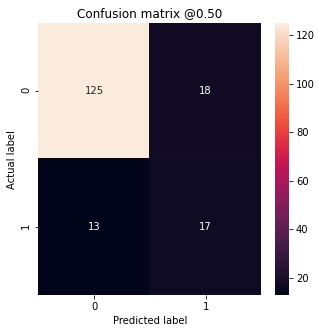

In [167]:
train_predictions_weighted = weighted_model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_weighted = weighted_model.predict(test_features, batch_size=BATCH_SIZE)
weighted_results = weighted_model.evaluate(test_features, test_labels,
                                           batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(weighted_model.metrics_names, weighted_results):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_weighted)

Модель с весами классов даёт неплохой результат, но всё ещё очень большая ошибка - 9

In [168]:
# чтобы попытаться улучшить модель, попробуем использовать бустрап-подход, а именно:
# уже существующие признаки случайным образом перенаберём, тем самым, позволим
# "лучше" нейронной сети понять закономерности взаимосвязи таргетного значения с признаками
bool_train_labels = train_labels != 0
pos_features = train_features[bool_train_labels]
neg_features = train_features[~bool_train_labels]
pos_labels = train_labels[bool_train_labels]
neg_labels = train_labels[~bool_train_labels]
ids = np.arange(len(pos_features))
choices = np.random.choice(ids, len(neg_features))
res_pos_features = pos_features[choices]
res_pos_labels = pos_labels[choices]
resampled_features = np.concatenate([res_pos_features, neg_features], axis=0)
resampled_labels = np.concatenate([res_pos_labels, neg_labels], axis=0)
order = np.arange(len(resampled_labels))
np.random.shuffle(order)
resampled_features = resampled_features[order]
resampled_labels = resampled_labels[order]
resampled_features.shape

(916, 24)

In [169]:
BUFFER_SIZE = 100000

def make_ds(features, labels):
  ds = tf.data.Dataset.from_tensor_slices((features, labels))#.cache()
  ds = ds.shuffle(BUFFER_SIZE).repeat()
  return ds

pos_ds = make_ds(pos_features, pos_labels)
neg_ds = make_ds(neg_features, neg_labels)

In [170]:
resampled_ds = tf.data.experimental.sample_from_datasets([pos_ds, neg_ds], 
                                                         weights=[0.5, 0.5])
resampled_ds = resampled_ds.batch(BATCH_SIZE).prefetch(2)

In [171]:
resampled_steps_per_epoch = np.ceil(2.0*neg/BATCH_SIZE)
resampled_model = make_model()
resampled_model.load_weights(initial_weights)

# Reset the bias to zero, since this dataset is balanced.
output_layer = resampled_model.layers[-1] 
output_layer.bias.assign([0])

val_ds = tf.data.Dataset.from_tensor_slices((val_features, val_labels)).cache()
val_ds = val_ds.batch(BATCH_SIZE).prefetch(2) 

resampled_history = resampled_model.fit(
    resampled_ds,
    epochs=EPOCHS,
    steps_per_epoch=resampled_steps_per_epoch,
    callbacks=[early_stopping],
    validation_data=val_ds)

Epoch 1/100
1/1 [==============================] - 3s 3s/step - loss: 1.0704 - tp: 268.0000 - fp: 377.0000 - tn: 811.0000 - fn: 765.0000 - accuracy: 0.4858 - precision: 0.4155 - recall: 0.2594 - auc: 0.3979 - val_loss: 0.6319 - val_tp: 9.0000 - val_fp: 30.0000 - val_tn: 84.0000 - val_fn: 15.0000 - val_accuracy: 0.6739 - val_precision: 0.2308 - val_recall: 0.3750 - val_auc: 0.5223
Epoch 2/100
1/1 [==============================] - 0s 53ms/step - loss: 1.0183 - tp: 281.0000 - fp: 402.0000 - tn: 670.0000 - fn: 695.0000 - accuracy: 0.4644 - precision: 0.4114 - recall: 0.2879 - auc: 0.4025 - val_loss: 0.6313 - val_tp: 9.0000 - val_fp: 30.0000 - val_tn: 84.0000 - val_fn: 15.0000 - val_accuracy: 0.6739 - val_precision: 0.2308 - val_recall: 0.3750 - val_auc: 0.5236
Epoch 3/100
1/1 [==============================] - 0s 46ms/step - loss: 1.0113 - tp: 281.0000 - fp: 384.0000 - tn: 649.0000 - fn: 734.0000 - accuracy: 0.4541 - precision: 0.4226 - recall: 0.2768 - auc: 0.4060 - val_loss: 0.6308 - va

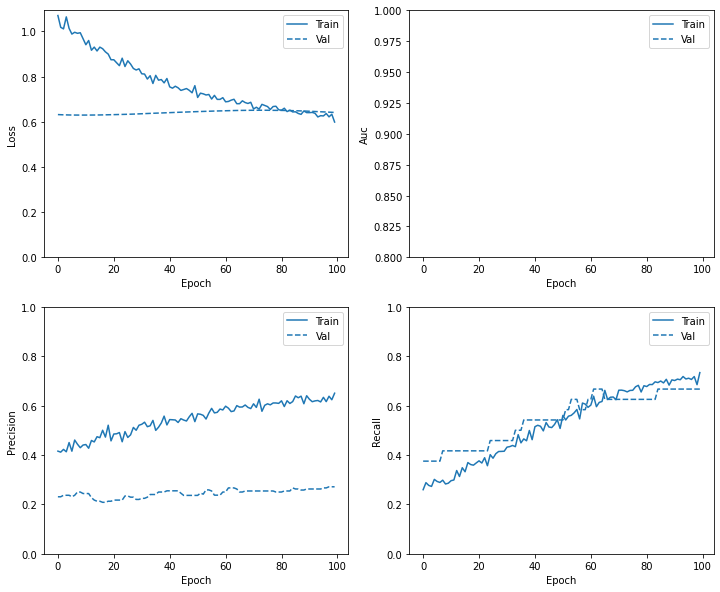

In [172]:
plot_metrics(resampled_history)

Epoch 1/1000
20/20 [==============================] - 3s 60ms/step - loss: 5.2710 - tp: 3423.2857 - fp: 4458.5238 - tn: 6921.1429 - fn: 7800.5238 - accuracy: 0.4561 - precision: 0.4243 - recall: 0.2959 - auc: 0.4035 - val_loss: 0.6612 - val_tp: 11.0000 - val_fp: 44.0000 - val_tn: 70.0000 - val_fn: 13.0000 - val_accuracy: 0.5870 - val_precision: 0.2000 - val_recall: 0.4583 - val_auc: 0.5693
Epoch 2/1000
20/20 [==============================] - 0s 19ms/step - loss: 3.9218 - tp: 4892.1429 - fp: 5130.3810 - tn: 6137.4762 - fn: 6270.4762 - accuracy: 0.4874 - precision: 0.4821 - recall: 0.4251 - auc: 0.4836 - val_loss: 0.7137 - val_tp: 15.0000 - val_fp: 60.0000 - val_tn: 54.0000 - val_fn: 9.0000 - val_accuracy: 0.5000 - val_precision: 0.2000 - val_recall: 0.6250 - val_auc: 0.6067
Epoch 3/1000
20/20 [==============================] - 0s 19ms/step - loss: 2.9938 - tp: 6652.1429 - fp: 5814.4286 - tn: 5452.1905 - fn: 4511.7143 - accuracy: 0.5358 - precision: 0.5295 - recall: 0.5816 - auc: 0.5616

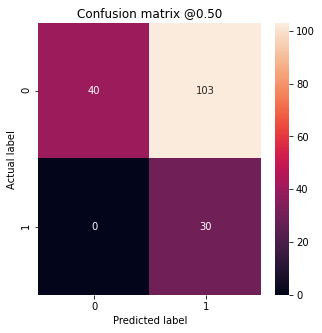

In [176]:
tf.random.set_seed(1234)
resampled_model = make_model()
resampled_model.load_weights(initial_weights)

# Reset the bias to zero, since this dataset is balanced.
output_layer = resampled_model.layers[-1] 
output_layer.bias.assign([0])

resampled_history = resampled_model.fit(
    resampled_ds,
    steps_per_epoch=20,
    epochs=10*EPOCHS,
    callbacks=[early_stopping],
    validation_data=(val_ds),
    class_weight={0:1, 1:7.3} # хотя и бустрап выборка в какой-то мере
    # сбалансирована, т.к. мы хотим нулевой уровень ложноотр.результата - 
    #определяем веса классов 
    )

train_predictions_resampled = resampled_model.predict(train_features, 
                                                      batch_size=BATCH_SIZE)
test_predictions_resampled = resampled_model.predict(np.array(X_test), 
                                                     batch_size=BATCH_SIZE)
valid_predictions_resampled = resampled_model.predict(np.array(X_val), 
                                                      batch_size=BATCH_SIZE)
resampled_results = resampled_model.evaluate(test_features, test_labels,
                                             batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(resampled_model.metrics_names, resampled_results):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_resampled)

Нейронные сети - лидер обучения - 100% чувствительность) и отличный recall (специфичность)

In [191]:
test_predictions_resampled = resampled_model.predict(np.array(X_test), 
                                                     batch_size=BATCH_SIZE)

In [192]:
test_predictions_resampled = list(map(lambda x: 
                                      np.round(x +.5) if x >=.5  # определение порога "перехода" к лейблу 1
                                      else x, test_predictions_resampled))

In [193]:
# определил предсказанное значение как признак
test_matrix['Neural_net'] = test_predictions_resampled 

## Стекинг моделей

Legitimate Transactions Detected (True Negatives):  33
Legitimate Transactions Incorrectly Detected (False Positives):  110
Fraudulent Transactions Missed (False Negatives):  0
Fraudulent Transactions Detected (True Positives):  30
Total Fraudulent Transactions:  30


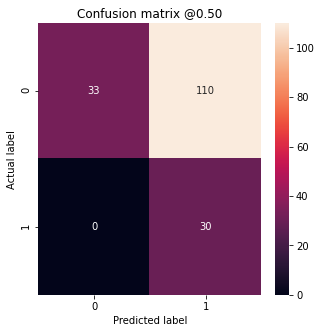

In [194]:
test_matrix['STACK'] = (test_matrix['Logistic'] + 
                        test_matrix['SVM'] +
                        test_matrix['CatBoost'] +
                        test_matrix['LGBM'] +
                        test_matrix["XGB"] + 
                        test_matrix["RF"] +
                        test_matrix['Neural_net'])
# Определил признак "Стэк", если он больше или равен 1 = 1, иначе = 0
test_matrix['STACK'] = test_matrix['STACK'].map(lambda 
                                                x: x + 1 - x 
                                                if x >= 1
                                                else 0)
plot_cm(Y_test, test_matrix['STACK'])

In [195]:
test_matrix[test_matrix['Actual_labels'] == 1]

,index,Logistic,SVM,CatBoost,LGBM,XGB,RF,Actual_labels,STACK,Neural_net
0,687,1,1,1,0,0,0,1,[1.0],[1.0]
2,155,0,0,0,0,0,0,1,[1.0],[1.0]
9,15,0,0,1,0,0,0,1,[1.0],[1.0]
19,771,1,1,1,1,0,0,1,[1.0],[1.0]
21,248,1,1,1,0,0,0,1,[1.0],[1.0]
22,582,1,1,1,1,1,1,1,[1.0],[1.0]
26,366,1,1,1,1,1,0,1,[1.0],[1.0]
27,732,0,0,1,0,0,0,1,[1.0],[1.0]
29,551,1,1,1,1,1,0,1,[1.0],[1.0]
38,577,1,1,1,1,0,0,1,[1.0],[1.0]


## Итог:


*   Целевой показатель ложнонегативное предсказание равен 0, что являлось принципиальным условием. Достичь удалось на бустрап-нейронной сети и стекинге
*   Лучшая модель способна снизить назначение антибиотиков с 95 % ( изначально) до 63 %, что очень неплохо.
* Поставленная цель достигнута при помощи глубокого обучения, чтобы улучшить модель необходимо больше данных
* Стекинг моделей может в какой-то мере улучшить предсказания, однако, в моём случае, модели обучения не смогли определить один случай необходимости АБ-терапии




